# Training Bu2023Ye model

**Abstract** This is a notebook where I try to train a surrogate model for the Bu2023Ye model.|

In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py
import tqdm
import inspect 

# NMMA imports
import nmma
from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans
from nmma.em.training import SVDTrainingModel
import nmma.em.model_parameters as model_parameters

# tensorflow imports
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16
        }

plt.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Install wrapt_timeout_decorator if you want timeout simulations.


2024-01-05 13:32:22.887175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 13:32:23.003192: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 13:32:23.575951: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: ~/MultiNest/lib/
2024-01-05 13:32:23.576056: W tensorflow/compiler/xla/stream_executor/

## Loading and exploring the dataset

In [2]:
lcs_dir = "/home/urash/twouters/KN_Lightcurves/lightcurves/bulla_2023"
model_name = "Bu2023Ye"

filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
print(f"There are {len(full_filenames)} lightcurves for this model.")

There are 33792 lightcurves for this model.


In [3]:
dat = pd.read_csv(full_filenames[0], delimiter=" ", escapechar='#')
dat = dat.rename(columns={" t[days]": "t"})
dat.head() # show first few rows

,t,sdssu,ps1::g,ps1::r,ps1::i,ps1::z,ps1::y,2massj,2massh,2massks,Unnamed: 10
0,0.103,-17.130,-16.909,-17.314,-16.282,-16.389,-15.942,-16.094,-10.886,-15.972,NaN
1,0.109,-19.091,-19.824,-19.942,-19.293,-19.654,-19.421,-19.040,NaN,-15.425,NaN
2,0.116,-19.754,-19.873,-19.537,-18.700,-18.927,-18.207,-19.835,-18.522,6.964,NaN
3,0.122,-18.931,-19.698,-19.497,-19.361,-18.508,-19.771,-18.812,-16.862,-15.640,NaN
4,0.130,-19.354,-19.786,-20.031,-18.963,-19.567,-19.251,-19.029,-18.540,-14.350,NaN


In [4]:
value_columns = dat.columns[1:-1] # discard first and last, to get "true" data columns
print(list(value_columns))

['sdssu', 'ps1::g', 'ps1::r', 'ps1::i', 'ps1::z', 'ps1::y', '2massj', '2massh', '2massks']


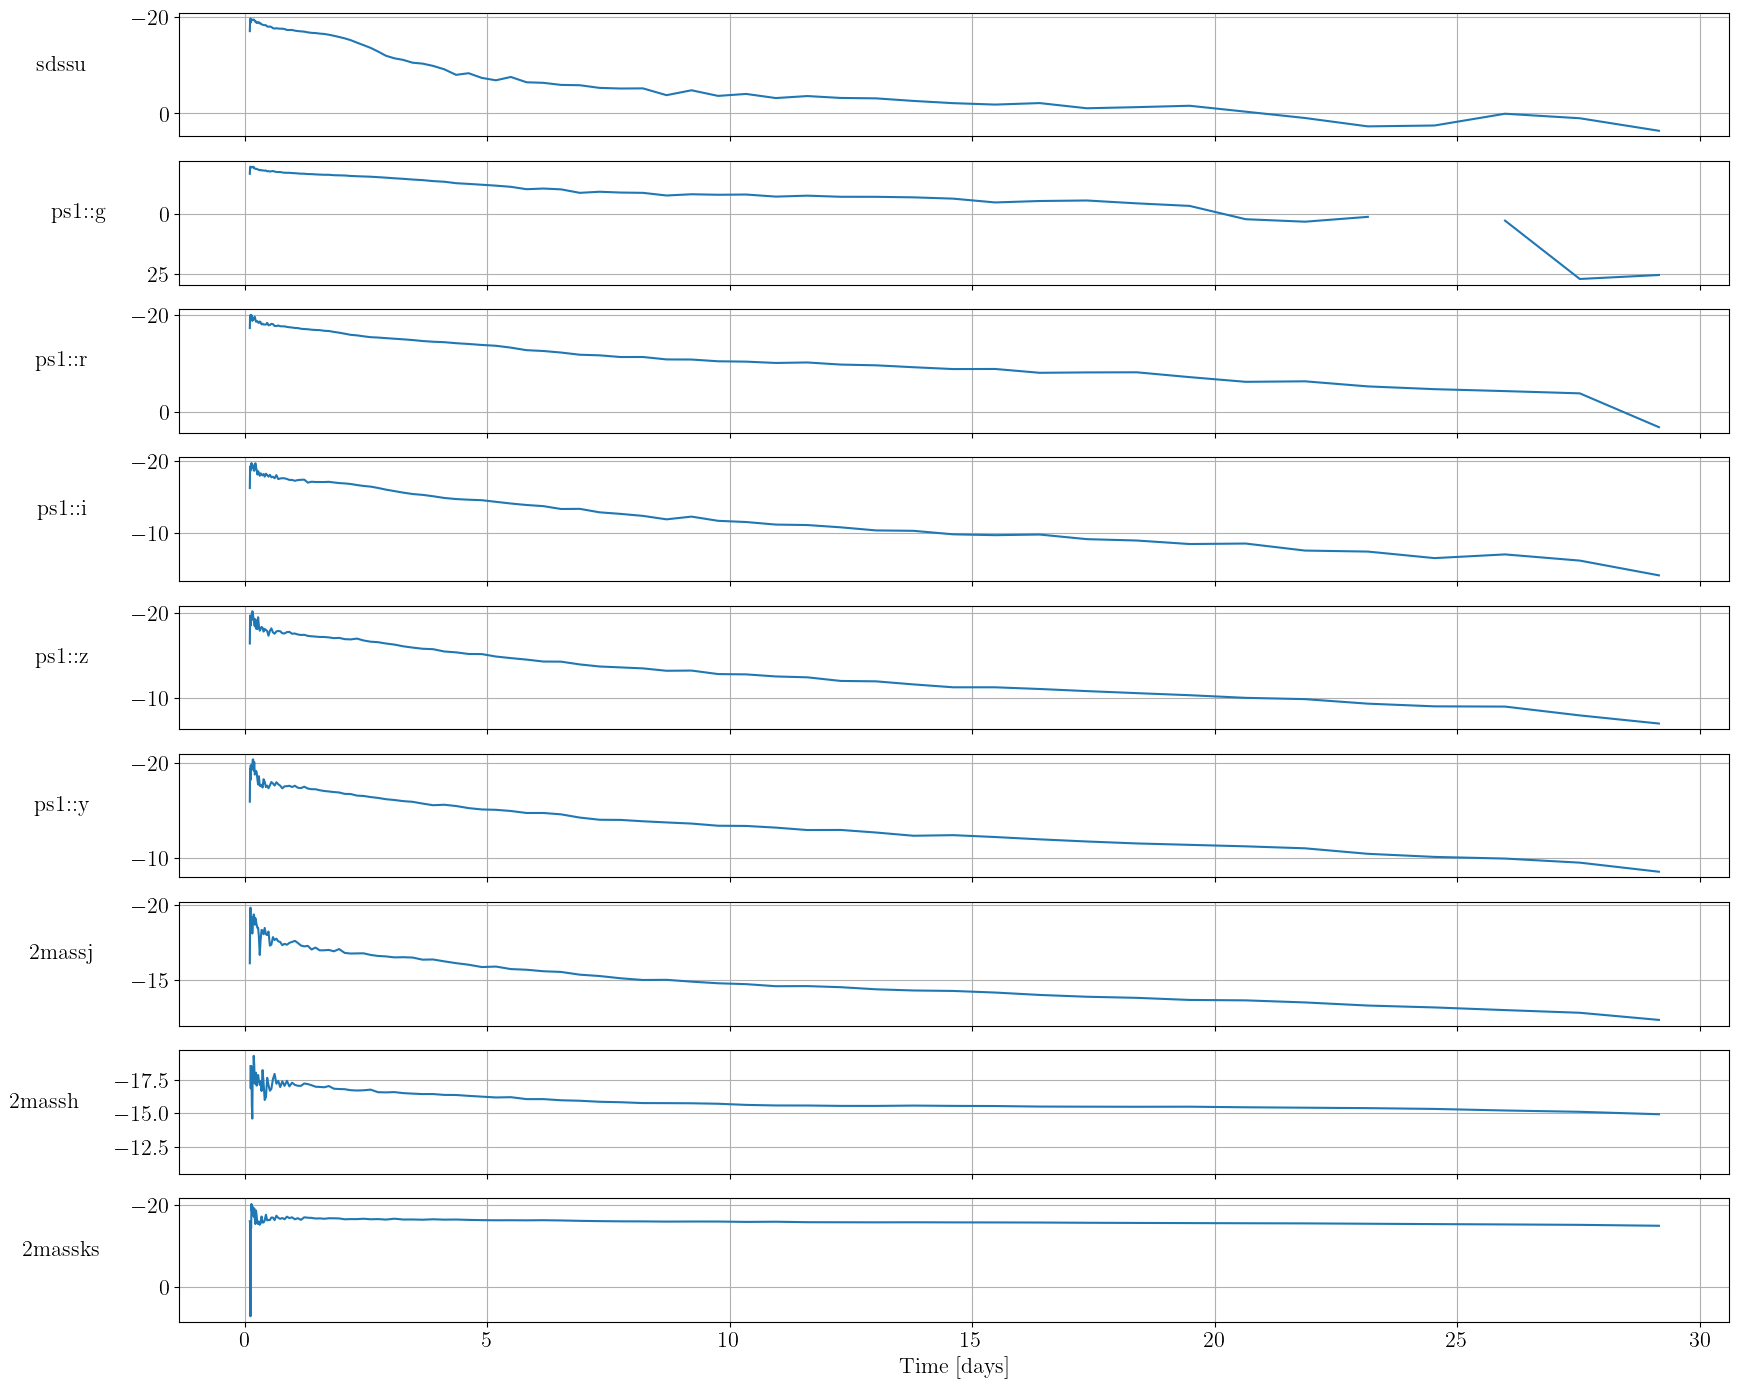

In [5]:
nrow = len(value_columns)
fig, axs = plt.subplots(nrow, 1, figsize=(20, 17), sharex = True)
t = dat["t"].values

for i, key in enumerate(value_columns):
    plt.subplot(nrow, 1, i+1)
    plt.plot(t, dat[key].values)
    plt.ylabel(key, rotation=0, labelpad=50)
    axs[i].invert_yaxis()
    # plt.grid()
plt.xlabel("Time [days]")
plt.show()

The following cell takes around 1 minute

In [6]:
data = read_photometry_files(full_filenames)
data = interpolate_nans(data)
keys = list(data.keys())
filts = sorted(list(set(data[keys[0]].keys()) - {"t"}))
print(filts)

['2massh', '2massj', '2massks', 'ps1__g', 'ps1__i', 'ps1__r', 'ps1__y', 'ps1__z', 'sdssu']


In [7]:
MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}
model_function = MODEL_FUNCTIONS[model_name]
training_data, parameters = model_function(data)

In [8]:
print(parameters)

['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'Yewind', 'KNtheta']


Check that the extraction of the parameters from the filenames makes sense

In [9]:
## There are two file name conventions here, so we have to check 
all_keys = list(training_data.keys())
first_file_names = [f for f in all_keys if f.startswith("MDyn")]
second_file_names = [f for f in all_keys if f.startswith("dyn")]

for example_key in [first_file_names[0], second_file_names[0]]:
    print("------------------")
    example_training_data = training_data[example_key]
    print(f"Keys (and some values) of dictionary of {example_key}")
    for key in example_training_data.keys():
        value = example_training_data[key]
        if key in parameters:
            print(f"{key} : {value}")

------------------
Keys (and some values) of dictionary of MDyn0.020_vDyn0.20_YeDyn0.30_MWind0.130_vWind0.05_YeWind0.2_theta53.13_dMpc0
log10_mej_dyn : -1.6989700043360187
vej_dyn : 0.2
Yedyn : 0.3
log10_mej_wind : -0.8860566476931633
vej_wind : 0.05
Yewind : 0.2
KNtheta : 53.13
------------------
Keys (and some values) of dictionary of dyn0.001-0.25-0.30_wind0.130-0.05_YeWind0.3_theta66.42_dMpc0
log10_mej_dyn : -3.0
vej_dyn : 0.25
Yedyn : 0.3
log10_mej_wind : -0.8860566476931633
vej_wind : 0.05
Yewind : 0.3
KNtheta : 66.42


## Getting SVD model

The following will take around 10 minutes

In [10]:
svd_ncoeff = 10
training_model = SVDTrainingModel(
        model_name,
        training_data,
        parameters,
        t,
        filts,
        n_coeff=svd_ncoeff,
        interpolation_type="tensorflow",
        svd_path = "/home/urash/twouters/new_nmma_models/Bu2023Ye_tf",
        start_training=False # don't train, just prep the data
        
    )

The grid will be interpolated to sample_time with interp1d


The following cell can take some time...|

In [11]:
svd_model = training_model.generate_svd_model()
training_model.svd_model = svd_model

Normalizing mag filter 2massh...
Normalizing mag filter 2massj...
Normalizing mag filter 2massks...
Normalizing mag filter ps1__g...


## Training

In [ ]:
first_filter = filts[0]

X = training_model.svd_model[first_filter]['param_array_postprocess']
n_samples, input_ndim = X.shape
print(f"Features (input) have shape {X.shape}")

y = training_model.svd_model[first_filter]['cAmat'].T
_, output_ndim = y.shape
print(f"Labels (output) have shape {y.shape}")

# Do the train validation split
train_X, val_X, train_y, val_y = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=0)


Features (input) have shape (33792, 7)
Labels (output) have shape (33792, 10)


In [ ]:
model = Sequential()
model.add(
    Dense(
        64,
        activation="relu",
        kernel_initializer="he_normal",
        input_shape=(train_X.shape[1],),
    )
)
model.add(
    Dense(
        128,
        activation="relu",
        kernel_initializer="he_normal",
        input_shape=(train_X.shape[1],),
    )
)
model.add(
    Dense(
        64,
        activation="relu",
        kernel_initializer="he_normal",
        input_shape=(train_X.shape[1],),
    )
)
model.add(Dense(training_model.n_coeff))

# Show the architecture:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                512       
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 17,738
Trainable params: 17,738
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam", loss="mse")
n_epochs = 30

# fit the model
training_history = model.fit(
    train_X,
    train_y,
    epochs=n_epochs,
    batch_size=32,
    validation_data=(val_X, val_y),
    verbose=True,
)

Epoch 1/30
951/951 [==============================] - 6s 6ms/step - loss: 0.0153 - val_loss: 0.0033
Epoch 2/30
951/951 [==============================] - 6s 6ms/step - loss: 0.0059 - val_loss: 0.0024
Epoch 3/30
951/951 [==============================] - 6s 6ms/step - loss: 0.0052 - val_loss: 0.0030
Epoch 4/30
951/951 [==============================] - 6s 6ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 5/30
951/951 [==============================] - 6s 6ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 6/30
951/951 [==============================] - 5s 6ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 7/30
951/951 [==============================] - 5s 6ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 8/30
951/951 [==============================] - 5s 6ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 9/30
951/951 [==============================] - 6s 6ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 10/30
951/951 [==============================] - 6s 6ms/step - loss: 0.0030 - val_loss: 0.0018

### Postprocessing - loss curves

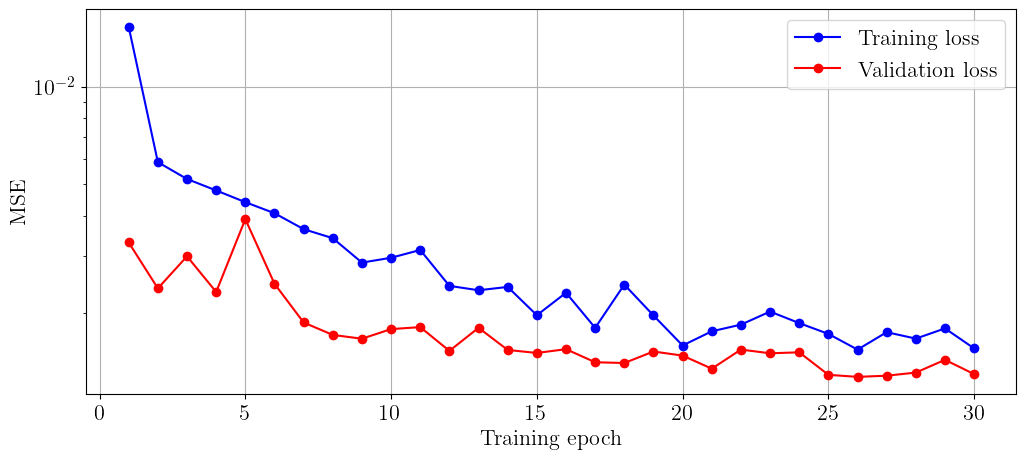

In [ ]:
train_loss = training_history.history["loss"]
val_loss = training_history.history["val_loss"]

plt.figure(figsize=(12, 5))
plt.plot([i+1 for i in range(len(train_loss))], train_loss, '-o', color="blue", label="Training loss")
plt.plot([i+1 for i in range(len(val_loss))], val_loss, '-o', color="red", label="Validation loss")
plt.legend()
plt.xlabel("Training epoch")
plt.ylabel("MSE")
plt.yscale('log')
plt.show()

## Checking the SVD
